In [1]:
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
from anchor import utils
from anchor import anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime
from lux.pyuid3.data import Data
from lux.pyuid3.uid3 import UId3
from lux.pyuid3.entropy_evaluator import UncertainEntropyEvaluator
from sklearn.neighbors import NearestNeighbors

/tmp/ipykernel_99624/1919619790.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
invalid escape sequence '\d'


In [2]:
def minmaxdf(df, scale=[-1,1]):
    # Using MinMaxScaler
    min_max_scaler = MinMaxScaler(feature_range=scale)    
    # Stack everything into a single column to scale by the global min / max
    tmp = df.to_numpy().reshape(-1,1)
    scaled = min_max_scaler.fit_transform(tmp).reshape(len(df), df.shape[1])
    return scaled
    

In [3]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Make moons

In [4]:
X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))

Xdf = pd.DataFrame(X, columns=['x1','x2'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['x1','x2']
X_test.columns = ['x1','x2']

<Axes: xlabel='x1', ylabel='x2'>

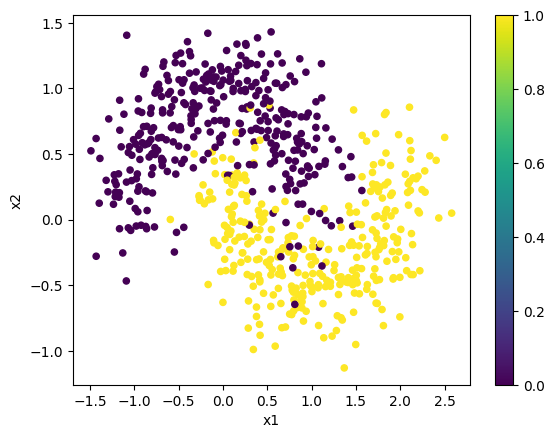

In [6]:
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis')

In [7]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.91      0.94      0.93       177

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [8]:
from sklearn.linear_model import LogisticRegression
xclf = LogisticRegression()
xclf.fit(X_train, y_train)
lr_preds = xclf.predict(X_test)

In [9]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.803030303030303
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       153
           1       0.82      0.81      0.81       177

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.80      0.80      0.80       330



<Axes: xlabel='x1', ylabel='x2'>

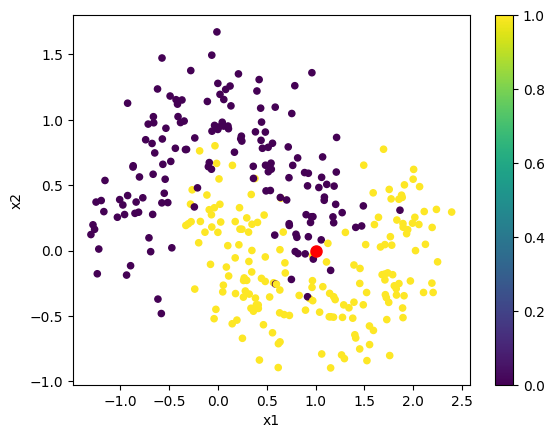

In [10]:
fig, ax = plt.subplots()
point = [1.0,0.0]
ax.plot(point[0], point[1], 'or', markersize=8)
X_test.plot(kind='scatter',x='x1', y='x2', c=y_test, colormap='viridis', ax=ax)

In [11]:
X_test_appended = pd.concat((X_test,pd.DataFrame([point], columns=['x1','x2'])))
y_test_appended = np.concatenate([y_test,[1]])

## Decision Boundaries

X does not have valid feature names, but SVC was fitted with feature names


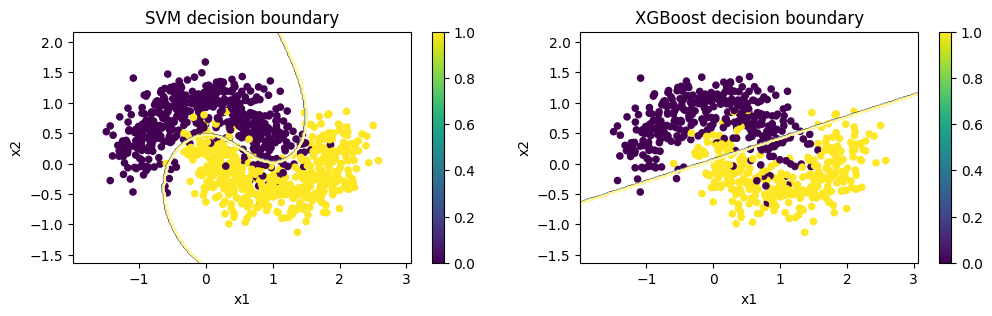

In [12]:

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='x1', y='x2',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

## Confidence plots

X does not have valid feature names, but SVC was fitted with feature names


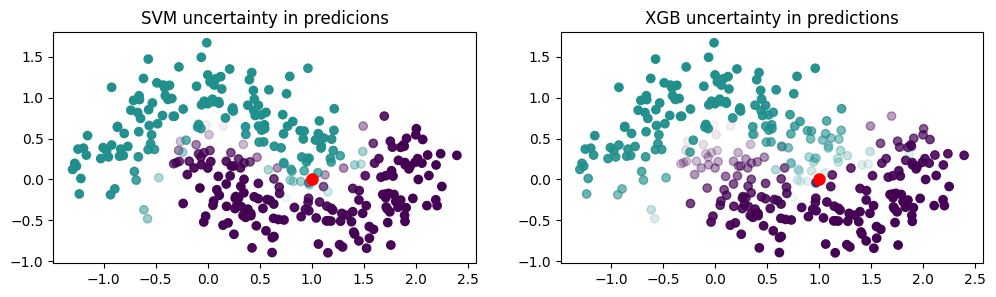

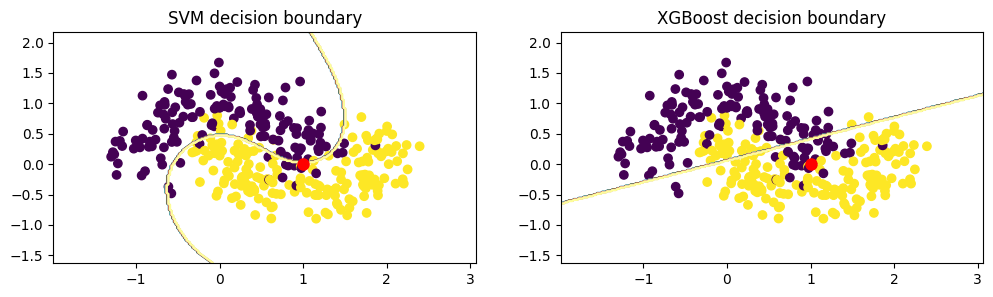

In [13]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_test_appended)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = xclf.predict_proba(X_test_appended)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_svc.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_xgb.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_xgb.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)


fig.savefig('uncertainty-point.png')

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
fig.savefig('decbound-point.png')
plt.show()

## Lime explanations

In [14]:
point

[1.0, 0.0]

In [15]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=list(X_train.columns), class_names=['0','1'], discretize_continuous=True)

In [16]:
idx = len(X_test_appended)-1
exp = explainer.explain_instance(X_test_appended.iloc[idx,:], svc.predict_proba, num_features=2, top_labels=1)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but SVC was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is dep

In [17]:
exp.show_in_notebook(show_table=True, show_all=False)

## Shap explanations

In [18]:
shap.initjs()

In [19]:
point

[1.0, 0.0]

In [20]:
import warnings
warnings.filterwarnings('ignore')

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svc.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test_appended, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
idx = len(X_test_appended)-1
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], X_test_appended.iloc[idx,:], link="logit")

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:16<00:00, 20.15it/s]


## Anchor explanations

In [21]:
explainer = anchor_tabular.AnchorTabularExplainer(
    ['0','1'],
    feature_names = X_train.columns,
    train_data = X_train.values,
    categorical_names={})

In [22]:
np.random.seed(1)
print('Prediction: ', explainer.class_names[svc.predict(X_test_appended.iloc[idx].values.reshape(1,-1))[0]])
exp = explainer.explain_instance(X_test_appended.iloc[idx].values, svc.predict, threshold=0.95)

Prediction:  1


In [23]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x2 <= 0.29 AND x1 > -0.17
Precision: 0.96
Coverage: 0.45


## LUX explanations

In [24]:
# select neighbourhood for explaned points (from train) (in this cas epoint only for the sake of simplicity)
# Use KNN to sample K-neighbours for each class
# export dataset(s) for UID3 and obtain rules
# highlight rule triggered for point example

In [25]:
nn = NearestNeighbors(n_neighbors=neighborhood_size)

In [26]:
X_pos_only = X_train[y_train==1]

In [27]:
nn.fit(X_pos_only)

NearestNeighbors(n_neighbors=100)

In [28]:
_,ids_1 = nn.kneighbors(np.array(point).reshape(1,-1))

In [29]:
ids_1

array([[ 50,  78,  80,  63, 205, 301, 165,  10,   8,  17, 139, 253,  82,
        297, 173, 228, 203, 187, 157,  12,  69,  23, 111, 279, 154, 178,
        305, 135, 108, 145, 322, 208, 234,  72, 156, 291, 198, 161,  86,
        160, 290, 222,  20, 114, 231, 199,  98, 183, 104,  15,  84, 251,
         47, 304, 211, 236, 210, 142, 249, 237,  26, 293, 319, 162, 219,
        192,  39, 243, 216, 186,   4, 227, 307,  95, 286, 179,  87, 131,
        164, 262, 272, 276,  57, 239,  46, 269, 256, 117, 106, 255,  89,
         25, 223, 153,  79, 287, 280, 235, 273, 226]])

In [30]:
X_neg_only = X_train[y_train==0]

In [31]:
nn.fit(X_neg_only)

NearestNeighbors(n_neighbors=100)

In [32]:
_,ids_0 = nn.kneighbors(np.array(point).reshape(1,-1))

In [33]:
ids_0

array([[277, 263, 330, 220,  45,  17,  57, 172,  24, 296,  59, 258, 151,
        256, 344,  93, 321,  19,  96,   0,  95,  40,  83, 232,  48, 235,
        291, 230, 298, 160, 334,  88,  20,  42,  22, 333, 300,   6, 332,
         44, 283, 159, 254,  47,  82, 294,  15, 236,  86, 121, 169,  23,
        341, 192, 229, 221, 242, 259,  99,  81, 239, 127, 133, 243,  28,
        208, 120, 252,  78, 268,  80,  63, 166, 264, 157, 197,  79, 108,
        267,  90,  13, 346, 132, 195,  11, 289,  75, 103, 269,  30, 126,
        137, 115, 185, 328, 201,  56, 327,  72, 265]])

In [34]:
X_train_sample = pd.concat((X_pos_only.iloc[ids_1.ravel()], X_neg_only.iloc[ids_0.ravel()]))

In [35]:
y_train_sample = svc.predict_proba(X_train_sample)[:,1]

## Neighbourhood plotting

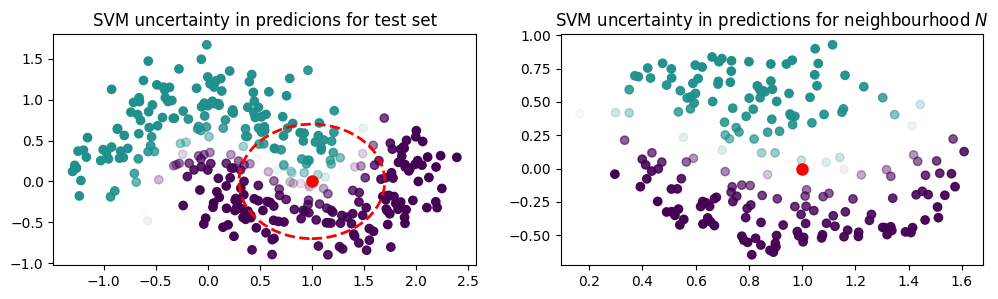

In [36]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

#y_test_proba_xg = xclf.predict_proba(X_train_sample)
#confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

y_test_proba_o = svc.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

#y_test_proba_xg_o = xclf.predict_proba(X_test_appended)
#confidence_xgb_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg_o[:,0],
#                                                                             'XGB_1':y_test_proba_xg_o[:,1]})))


y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
#ax[1].add_patch(rect)

fig.savefig('neighbourhood.png')

In [37]:
X_train_sample

,x1,x2
61,0.942120,0.007830
43,0.870092,-0.044982
329,1.016473,-0.158981
669,1.141565,0.083378
637,1.010963,-0.206081
...,...,...
415,0.164612,0.411515
572,1.114096,0.928072
189,0.371246,0.695537
336,0.475436,0.789671


### To UARFF

In [38]:
with open('lux.numeric.arff', 'w') as file:
    file.write('@relation lux\n\n')
    file.write('@attribute x1 @REAL\n')
    file.write('@attribute x2 @REAL\n')
    file.write('@attribute class {1,0}\n\n')
    
    file.write('@data\n')
    for i in range(0, len(X_train_sample)):
        file.write('{:.2f}'.format(X_train_sample.iloc[i,0])+'[1],'+'{:.2f}'.format(X_train_sample.iloc[i,1])+'[1],1['+'{:.2f}'.format(y_train_sample[i])+']\n')

## Train Uncertain Decision tree for whole decision boundary
Every instance can be explained with a path on this tree

In [39]:
data = Data.parse_uarff("./lux.numeric.arff")
uid3 = UId3(max_depth=2)
tree = uid3.fit(data, entropyEvaluator=UncertainEntropyEvaluator(), depth=0)

In [40]:
tree.save_dot('explanation.dot')

In [41]:
point

[1.0, 0.0]

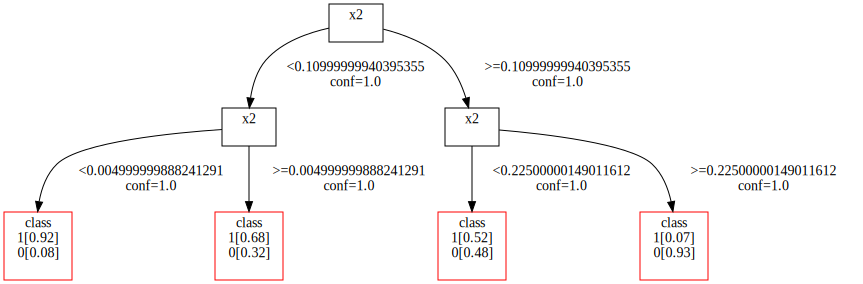

In [42]:
import graphviz
graphviz.Source.from_file('explanation.dot')

In [43]:
print(tree.to_HMR())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TYPES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%

xtype [
 name: class, 
base:symbolic,
 domain : [1,0]].
xtype [
 name: x2, 
base:numeric,
domain : [-100000 to 100000]].

%%%%%%%%%%%%%%%%%%%%%%%%% ATTRIBUTES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%
xattr [ name: class,
 type:class,
 class:simple,
 comm:out ].
xattr [ name: x2,
 type:x2,
 class:simple,
 comm:out ].

%%%%%%%%%%%%%%%%%%%%%%%% TABLE SCHEMAS DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%
 xschm tree : [x2]==> [class].
xrule tree/0:
[x2  lt 0.10999999940395355, x2  lt 0.004999999888241291] ==> [class set 1]. # 0.9217821782178218
xrule tree/1:
[x2  lt 0.10999999940395355, x2  gte 0.004999999888241291] ==> [class set 1]. # 0.6774999999999999
xrule tree/2:
[x2  gte 0.10999999940395355, x2  lt 0.22500000149011612] ==> [class set 1]. # 0.5155555555555557
xrule tree/3:
[x2  gte 0.10999999940395355, x2  gte 0.22500000149011612] ==> [class set 0]. # 0.9311538461538463

